---
title: "Pathway Analysis"
author: "Javier Millan Acosta"
date: 2024-11-28
---

## 1. Introduction

 > Note: adapted for Python from [Pathway-Analysis.Rmd](https://github.com/wikipathways/rWikiPathways/blob/devel/vignettes/Pathway-Analysis.Rmd).

This notebook will cover a wide range of analytical and visualization techniques involved in a typical pathway analysis. The **Overview** section will go into more detail on the particulars, but note that this vignette is designed to be modular and carefully considered. Please do not simply run the entire script and expect to get anything meaningful from the final output. This is an instructional device, ideal for guided workshops.

### 1.1. Installation

#### Packages
The following packages can be installed with the `pip` package installer.

In [ ]:
%pip install -r requirements.txt

In [2]:
import py4cytoscape as p4c
import pandas as pd
from biomart import BiomartServer
import pywikipathways as pwpw
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt
import json
import requests
from io import StringIO
import os

### 1.2. Cytoscape installation and setup

The `py4cytoscape` package is used to connect with **Cytoscape**. So you will also need to install and launch Cytoscape.

* Download the latest Cytoscape from https://cytoscape.org/download.html 
* Complete installation wizard
* Launch Cytoscape

In [3]:
p4c.cytoscape_ping()

You are connected to Cytoscape!


'You are connected to Cytoscape!'

For this vignette, you'll also need a couple *apps* for Cytoscape. With Cytoscape running, you can install each of these from the Cytoscape App Store with a single click:

* http://apps.cytoscape.org/apps/wikipathways
* http://apps.cytoscape.org/apps/cytargetlinker 

If you are running Cytoscape 3.7.0 or above, you can simply run these commands:

In [ ]:
p4c.install_app("CyTargetLinker")
p4c.install_app("WikiPathways")
p4c.install_app("stringApp")
p4c.install_app("enrichmentMap")

## 2. Overview

In this vignette, we will be performing functional enrichment analysis on a differential gene expression dataset. The dataset compares the expression of transcripts in lung cancer biopses versus normal tissue. Differential expression analysis has already been performed, generating log2foldchange and P-values for each gene. The enrichment analysis will be performed against Gene Ontology, as an introduction to the most common type of enrichment, commonly referred to as *GO Analysis*. This will serve as the foundation for more advanced enrichment analysis against a pathway database, which is called *Pathway Analysis*.

Working with pathways opens up unique analysis and visualization options. We will query WikiPathways for relevant content and import pathway models into Cytoscape. In Cytoscape, we will perform data overlays, add drug interactions and generate high-quality images for publication.

### 2.2. Dataset

The format of this lung cancer dataset should look familiar to anyone who has worked with differential gene expression results. It contains columns of gene identifiers (Ensembl IDs), gene symbols, log2FC values, P-Values and adjusted P-Values.

In [5]:
lung_expr = pd.read_excel(os.path.join("extdata", "lung-cancer-data.xlsx"))
lung_expr = lung_expr[
    lung_expr["GeneName"].apply(lambda x: isinstance(x, str))
]  # Need to clean datetime types added by Excel
lung_expr.sample(3)

,GeneID,GeneName,log2FC,P.Value,adj.P.Value
8823,ENSG00000146521,LINC01558,0.036464,0.962679,1.000000
26445,ENSG00000233477,PPIAP38,-0.661354,0.835649,1.000000
33145,ENSG00000258984,UBE2F-SCLY,1.362593,0.190051,0.463952


### 2.3. Up- and downregulated genes

Now let's prepare up- and down-regulated gene lists using some conventional criteria.

In [6]:
P_CUTOFF = 0.05

In [7]:
lung_expr["de"] = np.where(
    (lung_expr["log2FC"] > 1) & (lung_expr["adj.P.Value"] < P_CUTOFF),
    "upregulated",
    np.where(
    (lung_expr["log2FC"] < -1) & (lung_expr["adj.P.Value"] < P_CUTOFF), 
    "downregulated", 
    'bkgd'),)


In [8]:
lung_expr.describe(include="all")

,GeneID,GeneName,log2FC,P.Value,adj.P.Value,de
count,36814,36814,36814.000000,3.681400e+04,36814.000000,36814
unique,36786,36766,NaN,NaN,NaN,3
top,ENSG00000277739,RNA5-8S4,NaN,NaN,NaN,bkgd
freq,6,4,NaN,NaN,NaN,35791
mean,NaN,NaN,0.738960,3.990082e-01,0.584830,NaN
std,NaN,NaN,1.777559,3.646529e-01,0.339227,NaN
min,NaN,NaN,-8.742461,3.580000e-08,0.000853,NaN
25%,NaN,NaN,-0.139523,6.126635e-02,0.262821,NaN
50%,NaN,NaN,0.268689,2.912378e-01,0.560967,NaN
75%,NaN,NaN,1.479487,7.396475e-01,1.000000,NaN


<Axes: >

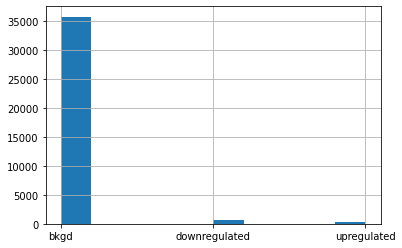

In [9]:
lung_expr.de.hist()

### 2.4. Mapping gene identifiers

We'll map our Ensembl identifiers to Entrez, as this is the admitted input for the `gseapy` enrichment functions we'll be using later on.
There are many tools one can use to map identifiers between databases. Note that these conversions may not always cover the whole dataset due to identifier deprecation or one-to-many mappings.

The example below uses [`BioMart`](http://www.ensembl.org/biomart):

In [10]:
def add_entrez_column_biomart(df, max_chunk_size=400):
    ensembl_ids = list(set(df['GeneID'].tolist()))
    entrez_dict = {}

    # Connect to the BioMart server
    server = BiomartServer("http://www.ensembl.org/biomart")
    dataset = server.datasets["hsapiens_gene_ensembl"]

    # Split ensembl_ids into chunks if necessary and fetch results
    for i in range(0, len(ensembl_ids), max_chunk_size):
        chunk = ensembl_ids[i:i + max_chunk_size]
        response = dataset.search(
            {
                "filters": {"ensembl_gene_id": chunk},
                "attributes": ["ensembl_gene_id", "entrezgene_id"],
            }
        )
        if response.status_code == 200:
            print(f"{i // max_chunk_size + 1} chunks sent", end="\r", flush=True)
            # Parse results
            for line in response.iter_lines(decode_unicode=True):
                ensembl, entrez = line.split("\t")
                entrez_dict[ensembl] = entrez if entrez else None
        else:
            print(
                response.status_code,
                " - request unsuccessful for chunk starting at index ",
                i
            )

    # Map the entrez IDs to the dataframe
    df = df.copy()
    df['entrezID'] = df['GeneID'].map(entrez_dict)

    return df

biomart_df = add_entrez_column_biomart(lung_expr)
print(len(set(biomart_df.entrezID)), " ids mapped")
biomart_df.sample(5)

23136  ids mapped


,GeneID,GeneName,log2FC,P.Value,adj.P.Value,de,entrezID
3656,ENSG00000109436,TBC1D9,-0.754440,0.032011,0.204393,bkgd,23158
1797,ENSG00000088930,XRN2,-0.116049,0.714354,1.000000,bkgd,22803
4101,ENSG00000112812,PRSS16,-0.013214,0.979128,1.000000,bkgd,10279
15920,ENSG00000185862,EVI2B,-1.733936,0.000473,0.036285,downregulated,2124
34116,ENSG00000264204,AGAP7P,1.888521,0.085894,0.304664,bkgd,653268


The example below uses [`BridgeDB`](https://webservice.bridgedb.org):

In [ ]:
def add_entrez_column_bridgedb(df, chunk_size = 300):
    ids = set(df["GeneID"].tolist())
    entrez_ids = {}

    for i in range(0, len(ids), chunk_size):
        chunk = list(ids)[i : i + chunk_size]
        response = requests.post(
            "https://webservice.bridgedb.org/Human/xrefsBatch/En",
            headers={"Content-Type": "text/plain", "accept": "application/json"},
            data="\n".join(chunk),
        )
        if response.status_code == 200:
            print(f"{i // chunk_size + 1} chunks sent", end="\r", flush=True)
            res = response.json()
            chunk_entrez_ids = {
                ensembl: item.split("L:")[1]
                for ensembl in res
                for item in res[ensembl]["result set"]
                if "L:" in item
            }

            entrez_ids.update(chunk_entrez_ids)
        else:
            print(
                response.status_code,
                " - request unsuccessful for chunk starting at index ",
                i,
                end="\r",
            )

    df["entrezID"] = df["GeneID"].map(entrez_ids)
    return df

bdb_df = add_entrez_column_bridgedb(lung_expr)
print(len(set(bdb_df.entrezID)), " ids mapped", flush=True)
bdb_df.sample(5)

Which mappings database gave us better coverage?

In [ ]:
biomart_len = len(set(biomart_df.entrezID))
bdb_len = len(set(bdb_df.entrezID))
print(f"Biomart: {biomart_len}\nBridgeDb: {bdb_len}")

In [26]:
if biomart_len > bdb_len:
    lung_expr = biomart_df
else:
    lung_expr = bdb_df

Conversions weren't complete. What's our coverage?

> **Notice the unmapped genes will be left out of the analyses!**

In [ ]:
print(
    round((len(set(lung_expr.GeneID)) - len(set(lung_expr.entrezID))) / 
          len(set(lung_expr.GeneID)) * 100),
    "%")

## 3. Enrichment
### 3.1. Gene Ontology Enrichment

Let's start with Gene Ontology. We'll go with `GO_Biological_Process_2023` for an up-to-date enrichment in biological processes the gene sets are involved in.



For **downregulated** genes:

In [ ]:
dr = gp.enrichr(
    gene_list=lung_expr[lung_expr.de == "downregulated"].GeneName,
    background=lung_expr.GeneName,
    gene_sets="GO_Biological_Process_2023",
    organism="human",
    outdir="enrichr_results",
    no_plot=True,
    verbose=True,
    cutoff=P_CUTOFF,
).res2d
# Add gene count
dr["gene_count"] = [len(row.Genes.split(";")) for _, row in dr.iterrows()]
# Arbitrary adj.P-Val cutoff
dr = dr[dr["Adjusted P-value"] < P_CUTOFF]
# View results
dr

For **upregulated** genes:

In [ ]:
ur = gp.enrichr(
    gene_list=lung_expr[lung_expr.de == "upregulated"].GeneName,
    background=lung_expr.GeneName,
    gene_sets="GO_Biological_Process_2023",
    organism="human",
    outdir="enrichr_results",
    no_plot=True,
    verbose=True,
    cutoff=0.05,
).res2d
# Add gene count
ur["gene_count"] = [len(row.Genes.split(";")) for _, row in ur.iterrows()]
# Arbitrary adj.P-Val cutoff
ur = ur[ur['Adjusted P-value'] < P_CUTOFF]
# View results
ur

In [ ]:
ur.describe()

In [ ]:
dr.describe()

#### Visualizing GO enrichment results

In [18]:
def plot_enrichment(df, number, type, geneset="GO"):
    top = (
        df
            .sort_values(by="Adjusted P-value", ascending=True)
            .head(number)
            .sort_values(by="gene_count", ascending=False)
    )

    # Plot the top 100 terms
    plt.figure(figsize=(10, 20))
    plt.barh(top['Term'], top['gene_count'], color='skyblue')
    plt.xlabel('Gene Count')
    plt.ylabel('GO Terms')
    plt.title(f"Top {number} {geneset} Terms by Gene Count, type = {type}, Adj. P-Value < {P_CUTOFF}")
    plt.gca().invert_yaxis()
    plt.show()
    return plt

In [ ]:
plot_enrichment(ur, 100, "upregulated")

In [ ]:
plot_enrichment(dr, 100, "downregulated")

Overlap?

In [ ]:
overlaps = [
    [
        rowi.Term,
        len(list(set(rowi.Genes.split(";") + rowj.Genes.split(";")))),
        #list(set(rowi.Genes.split(";") + rowj.Genes.split(";"))),
        len(list(set(rowi.Genes.split(";")))),
        len(list(set(rowj.Genes.split(";") ))),
        
    ]
    for _, rowi in ur.iterrows()
    for _, rowj in dr.iterrows()
    if rowi.Term == rowj.Term
]
ol_df = pd.DataFrame(
    overlaps, columns=["term", "genecount", "genes_up", "genes_down"]
).sort_values(by="genecount", ascending=False)
ol_df.describe()

In [ ]:
total = len(set(dr.Term)) + len(set(ur.Term))
print(
    f"{len(ol_df)}/{total} OVERLAPPING GO BIOLOGICAL PROCESS TERMS BETWEEN UPREGULATED AND DOWNREGULATED SETS ({round(len(ol_df)/total*100, 2)}%)"
)
ol_df

Repeat analysis without overlapping

In [ ]:
dr_clean = dr[dr["Term"].isin(ol_df.term.to_list())]
ur_clean = ur[ur["Term"].isin(ol_df.term.to_list())]
dr_clean.describe()

In [ ]:
ur_clean.describe()

In [ ]:
plot_enrichment(ur[ur.Term.isin(list(ol_df.term))], 100, "upregulated, overlapping")

In [ ]:
plot_enrichment(dr[dr.Term.isin(list(ol_df.term))], 100, "downregulated, overlapping")

### 3.2 WikiPathways Enrichment 
That's all well and fine, but we are here for *Pathway Analysis!*  Everything up to this point is basic GO analysis. Building on top of this foundation, let's see what WikiPathways can add. The `gseapy` package includes built-in support for WikiPathways gene sets (see https://maayanlab.cloud/Enrichr/#libraries).

Thus, for downregulated genes:

In [ ]:
ewp_dr = gp.enrichr(
    gene_list=lung_expr[lung_expr.de == "downregulated"].GeneName,
    background=lung_expr.GeneName,
    gene_sets="WikiPathways_2024_Human",
    organism="human",
    outdir="enrichr_results",
    no_plot=True,
    verbose=True,
    cutoff=0.05,).res2d
# View the results
ewp_dr.head()

In [ ]:
ewp_dr["gene_count"] = [len(row.Genes.split(";")) for _, row in ewp_dr.iterrows()]
# Arbitrary adj.P-Val cutoff
ewp_dr = ewp_dr[ewp_dr["Adjusted P-value"] < P_CUTOFF]
# View results
ewp_dr.head()

And upregulated:

In [ ]:
ewp_ur = gp.enrichr(
    gene_list=lung_expr[lung_expr.de == "upregulated"].GeneName,
    background=lung_expr.GeneName,
    gene_sets="WikiPathways_2024_Human",
    organism="human",
    outdir="enrichr_results",
    no_plot=True,
    verbose=True,
    cutoff=0.05,
).res2d
# View the results
ewp_ur.head()

In [ ]:
ewp_ur["gene_count"] = [len(row.Genes.split(";")) for _, row in ewp_ur.iterrows()]
# Arbitrary adj.P-Val cutoff
ewp_ur = ewp_dr[ewp_dr["Adjusted P-value"] < P_CUTOFF]
# View results
ewp_ur.head()

In [ ]:
plot_enrichment(ewp_dr, 100, "downregulated", "WikiPathways")

In [ ]:
plot_enrichment(ewp_ur, 100, "upregulated", "WikiPathways")

plot_enrichment(ewp_ur, 100, "upregulated", "WikiPathways")

You can retrieve the WP ids from the `Term` column:

In [ ]:
def add_wpid_col(df):
    wpid = ['WP'+row.Term.split("WP")[1] for _, row in df.iterrows()]
    df['wpid'] = wpid
    return df

ewp_ur, ewp_dr = add_wpid_col(ewp_ur), add_wpid_col(ewp_ur)
ewp_ur.sample(4)

#### Explore
Turning again to the **pyWikiPathways** package, let's explore the content and some of our pathway hits so far. Since we are studying Lung Cancer here, let's start with a search for relevant pathways...

In [ ]:
lc_pathways = pwpw.find_pathways_by_text("lung cancer")
lc_pathways = lc_pathways[lc_pathways.species == "Homo sapiens"]
lc_pathways
# Differences with R workflows: find_pathway_names_by_text method DOES NOT ALLOW to filter by species like the R version findPathwayNamesByText, need to use find_pathways_by_text instead

Ok, so there are just a few human pathways that explicitly mention "lung cancer" in their titles or descriptions. How many of these were in our top hits for enrichment?

In [ ]:
enrichment_ids = pd.concat([ewp_dr, ewp_ur]).wpid
common = [
    enrichment_id
    for i, enrichment_id in enumerate(enrichment_ids)
    if enrichment_id in lc_pathways.id.values
]
print(len(indices), " pathways:\n-", "\n- https://wikipathways.org/pathways/".join(common))

#### Exploring pathways and importing them into Cytoscape with RCy3

In [ ]:
url = pwpw.get_pathway_info("WP179")
print(url['url'])

In [ ]:
cmd_list = ["wikipathways", "import-as-pathway", "id=WP179"]
cmd = " ".join(cmd_list)
p4c.commands.commands_get(cmd)
p4c.notebook_export_show_image()


### Mapping gene expression data onto pathways in Cytoscape

In [ ]:
p4c.load_table_data(lung_expr, data_key_column="GeneID", table_key_column="Ensembl")

### Setting visual styles in Cytoscape
Now we can define visual styles to visualize our data on this pathway. First, let's set the node fill color to display the log2 fold change data. 

In [ ]:
p4c.set_node_color_mapping("log2FC", [-1, 0, 1], ["#67001f", "#ffffff","#053061"], style_name="WikiPathways")
# TODO report difference (R--> "WikiPathways"; Python: "WikiPathways-As-Network"")
p4c.notebook_export_show_image()

You can similarly map P-values to border color, etc. There are dozens and dozens of visual properties on nodes and edges available for data visualization!

The power of scripting is in doing something multiple times though... So, let's now apply this same data and visual style to the first 5 pathways we are interested in. In just two lines of code...



In [ ]:
for pathway_id in lc_pathways.id[:5]:
    cmd = f"wikipathways import-as-pathway id={pathway_id}"
    p4c.commands.commands_get(cmd)
    p4c.load_table_data(lung_expr.copy(), data_key_column="GeneID", table_key_column="Ensembl")
    p4c.toggle_graphics_details()

### Extend
Now that our pathways are loaded into Cytoscape, this opens up a ton of potential analysis and visualizations options! Check out the [Cytoscape manual](http://manual.cytoscape.org) and [App Store](http://apps.cytoscape.org/), for starters. You might also browse the [Cytoscape tutorials](http://tutorials.cytoscape.org/) and [RCy3 vignettes](https://bioconductor.org/packages/release/bioc/vignettes/RCy3/inst/doc/Overview-of-RCy3.html) (for R) if you want hands-on examples.

In this notebook, we will use the *CyTargetLinker* app for Cytoscape to extend a network representation of our pathway with drug-target interactions.

First, let's reimport our pathway *as a network* using this slightly modified command:

In [ ]:
p4c.commands.commands_get('wikipathways import-as-network id=WP179')
p4c.load_table_data(lung_expr, data_key_column="GeneID", table_key_column="Ensembl")
p4c.set_node_color_mapping("log2FC", [-1, 0, 1], ["#67001f", "#ffffff", "#053061"], style_name="WikiPathways-As-Network")
p4c.notebook_export_show_image()

See the difference?  Same data, same pathway source, but different representation. The network view of pathways is useful when you want to add more nodes, traverse paths, perform automatic layouts, etc.

Next, we need to load the latest drug-target database. The databases supported by **CyTargetLinker** are called *linksets* and can be downloaded from the [CyTargetLinker website](https://projects.bigcat.unimaas.nl/cytargetlinker/linksets/). We have provided an example **drugbank** linkset for this vignette, so you don't have to download anything.

In [ ]:
unzip(
    system.file("extdata", "drugbank-5.1.0.xgmml.zip", package="rWikiPathways"),
    exdir=getwd(),
)
drugbank < -file.path(getwd(), "drugbank-5.1.0.xgmml")

Now that we have our *drugbank* linkset  loaded, we can run CyTargetLinker as a command:


In [ ]:
commandsRun(
    paste0('cytargetlinker extend idAttribute="Ensembl" linkSetFiles="', drugbank, '"')
)
commandsRun('cytargetlinker applyLayout network="current"')

This returns information about what was added. And in Cytoscape, you now have a copy of your original network, but now with additional nodes and edges. Check it out...

...Hmm, they are kind of plain and hard to see. Let's use Cytoscape visualization styles to fix that!

In [ ]:
my.drugs <- selectNodes("drug", by.col = "CTL.Type", preserve = FALSE)$nodes #easy way to collect node SUIDs by column value
clearSelection()
setNodeColorBypass(my.drugs, "#DD99FF")
setNodeShapeBypass(my.drugs, "hexagon")

drug.labels <- getTableColumns(columns=c("SUID","CTL.label"))
drug.labels <- na.omit(drug.labels)
mapply(function(x,y) setNodeLabelBypass(x,y), drug.labels$SUID, drug.labels$CTL.label)